In [ ]:
# if needed install packages:
#!pip install -r requirements.txt --use-deprecated=legacy-resolver
import os
HOME = r"/content/drive/MyDrive/gather/ML-DL-scripts/DEEP LEARNING/segmentation/Segmentation pipeline"
os.chdir(HOME)

In [2]:
import model_comparison
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import minmax_scale
from keras.models import load_model
import numpy as np


# 1) Example Code to load and show images, models and predictions

In [3]:
data_loader = model_comparison.DataGeneratorFolder(root_dir='./osm_data',
                                                   image_folder='images_256x256/images',
                                                   mask_folder='masks_256x256/masks',
                                                   batch_size=1,
                                                   nb_y_features=1,
                                                   #augmentation = aug_with_crop
                                                   )


In [4]:
# look at example images and predictions by the model:
model_trained_on_massachussets = load_model('model_short.h5', compile=False)
model_trained_on_madagascar = load_model(
    f"cached_intermediate_data/model_massachussettes_madagascar_fold1.h5", compile=False)


current image: image_0001.png
original image:


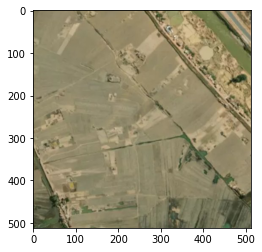

true mask:


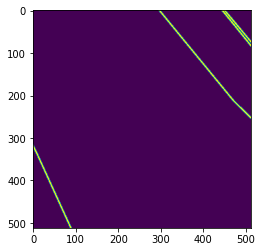

predicted mask:


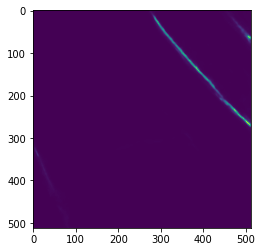

IOU 3.034901365705615e-13
--------------------------------------------------------------------------------
current image: image_0002.png
original image:


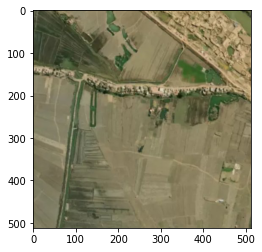

true mask:


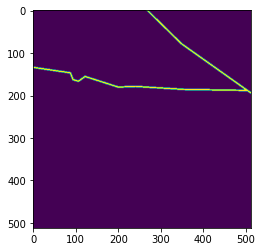

predicted mask:


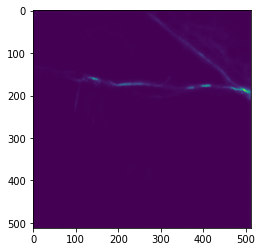

IOU 3.067484662576687e-13
--------------------------------------------------------------------------------
current image: image_0003.png
original image:


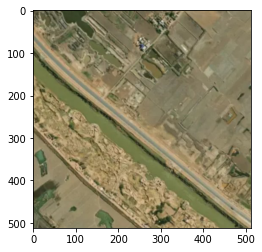

true mask:


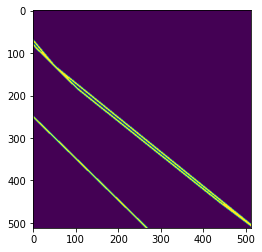

predicted mask:


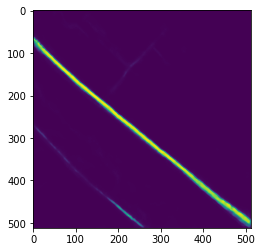

IOU 0.2477747678018576
--------------------------------------------------------------------------------


In [5]:
for i in range(0, 3):
    Xtest, yest = data_loader.__getitem__(i)
    print(f"current image: {data_loader.get_image_name_at_index(i)}")
    ypred = model_trained_on_madagascar.predict(Xtest)
    # fit on the same data as predicted on, overfitting possible, just for illustration
    print("original image:")
    plt.imshow(Xtest[0])
    plt.show()
    print("true mask:")
    plt.imshow(yest[0, :, :, 0])
    plt.show()
    print("predicted mask:")
    plt.imshow(ypred[0, :, :, 0])
    plt.show()
    y_true_in = yest[0].reshape(Xtest.shape[1], Xtest.shape[2])
    y_pred = ypred.reshape(Xtest.shape[1], Xtest.shape[2])
    print('IOU', model_comparison.iou_metric(y_true_in, y_pred)[0][0][0])
    # iou calculation with treshold of 0.5, 
    #so very light lines in prediction are not counted as roads, threshold tuning is still to be done
    print("-" * 80)      
    


# 2) Define and Perform Cross Validation
Remark: The models have been trained and cached before to allow modularization

# 2a) Define wrappers for different models

In [6]:
# constant predictors:
class All_0_Predictor:
    def predict(self, X_test_image):
        return np.zeros(shape=(1, X_test_image.shape[1], X_test_image.shape[2], 1))


class All_1_Predictor:
    def predict(self, X_test_image):
        return np.ones(shape=(1, X_test_image.shape[1], X_test_image.shape[2], 1))


In [7]:
def get_model(model_name, fold_number):
    if model_name == "Massachusetts":
        return load_model('model_massachusetts.h5', compile=False)

    if model_name == "Madagascar":
        return load_model(f"model_madagascar_fold{fold_number}.h5", compile=False)

    if model_name == "Madagascar_and_Massachusetts":
        return load_model(f"cached_intermediate_data/model_massachussettes_madagascar_fold{fold_number}.h5", compile=False)

    if model_name == "unet_encoder_architecture2":
        return model_comparison.UnetEncoderWrapper(fold_number)

    if model_name == "unet_encoder_architecture2_512":
        return model_comparison.UnetEncoderWrapper(fold_number, 512)

    if model_name == "predict_all_0s":
        return All_0_Predictor()

    if model_name == "predict_all_1s":
        return All_1_Predictor()

    raise Exception(
        f"no model found. for model {model_name} and fold {fold_number}")


# 2b) Perform Cross-Validation

In [8]:
IMAGE_FOLDER = './osm_data/images_256x256/images'
MODEL_NAMES = [
    # "unet_encoder_architecture2_512",
    # "unet_encoder_architecture2",
    "predict_all_0s",
    "predict_all_1s",
    # unet model trained on madagascar data (out of sample)
    "Madagascar",
    "Massachusetts",  # unet model trained on massachussetts
    "Madagascar_and_Massachusetts",  # unet model trained on both
]
df_results_per_image = model_comparison.perform_cv(
    IMAGE_FOLDER, MODEL_NAMES, get_model, data_loader)


--------------------------------------------------------------------------------
evaluating fold number: 1 of 5
--------------------------------------------------------------------------------
evaluating model: predict_all_0s
currently evaluating image number 0 of 110... 
currently evaluating image number 25 of 110... 
currently evaluating image number 50 of 110... 
currently evaluating image number 75 of 110... 
currently evaluating image number 100 of 110... 
--------------------------------------------------------------------------------
evaluating model: predict_all_1s
currently evaluating image number 0 of 110... 
currently evaluating image number 25 of 110... 
currently evaluating image number 50 of 110... 
currently evaluating image number 75 of 110... 
currently evaluating image number 100 of 110... 
--------------------------------------------------------------------------------
evaluating model: Madagascar
currently evaluating image number 0 of 110... 
currently evaluating im

# 3) Evaluate CV results

# 3a) Results per image 


In [9]:
pd.options.display.float_format = '{:,.2f}'.format
df_results_per_image.model = df_results_per_image.model.str.replace(
    "Madagascar_and_Massachusetts", "Madagascar and Massachusetts")
df_results_per_image.model = df_results_per_image.model.str.replace(
    "predict_all_1s", "Constant 1 Predictor")
df_results_per_image.model = df_results_per_image.model.str.replace(
    "predict_all_0s", "Constant 0 Predictor")

df_results_per_image["accuracy"] = (df_results_per_image.TP + df_results_per_image.TN) / (
    df_results_per_image.TP + df_results_per_image.TN + df_results_per_image.FP + df_results_per_image.FN)
df_results_per_image["precision"] = (
    df_results_per_image.TP) / (df_results_per_image.TP + df_results_per_image.FP)
df_results_per_image["recall"] = (
    df_results_per_image.TP) / (df_results_per_image.TP + df_results_per_image.FN)

df_results_per_image


,model,image_name,indexes,iou,fold_number,TN,FP,FN,TP,accuracy,precision,recall
0,Constant 0 Predictor,image_0001.png,0,0.00,1,"259,190.00",0.00,"2,954.00",0.00,0.99,NaN,0.00
1,Constant 0 Predictor,image_0004.png,3,1.00,1,"262,144.00",0.00,0.00,0.00,1.00,NaN,NaN
2,Constant 0 Predictor,image_0005.png,4,0.00,1,"260,199.00",0.00,"1,945.00",0.00,0.99,NaN,0.00
3,Constant 0 Predictor,image_0006.png,5,0.00,1,"254,396.00",0.00,"7,748.00",0.00,0.97,NaN,0.00
4,Constant 0 Predictor,image_0010.png,9,0.00,1,"251,878.00",0.00,"10,266.00",0.00,0.96,NaN,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2735,Madagascar and Massachusetts,image_0512.png,511,0.16,5,"257,527.00","1,347.00","2,535.00",735.00,0.99,0.35,0.22
2736,Madagascar and Massachusetts,image_0514.png,513,0.00,5,"261,959.00",0.00,185.00,0.00,1.00,NaN,0.00
2737,Madagascar and Massachusetts,image_0523.png,522,0.08,5,"251,527.00",851.00,"8,888.00",878.00,0.96,0.51,0.09
2738,Madagascar and Massachusetts,image_0524.png,523,0.15,5,"251,761.00","2,288.00","6,556.00","1,539.00",0.97,0.40,0.19


#3b) Average results per model

In [10]:
df_results = df_results_per_image.groupby(["model", "fold_number"]).mean().groupby("model").mean().loc[:, [
    "iou", "accuracy", "precision", "recall", "TP", "FN",  "FP",
    "TN"]].sort_values("iou",  ascending=False)
# to be exact we first group by fold_number to really get the average results per fold
df_results


,iou,accuracy,precision,recall,TP,FN,FP,TN
model,,,,,,,,
Madagascar,0.21,0.95,0.29,0.43,"3,860.66","4,911.67","8,613.18","244,758.49"
Madagascar and Massachusetts,0.17,0.96,0.35,0.24,"2,281.23","6,491.09","3,976.18","249,395.49"
Massachusetts,0.06,0.97,0.33,0.04,418.33,"8,354.00",642.92,"252,728.76"
Constant 1 Predictor,0.03,0.03,0.03,1.00,"8,772.33",0.00,"253,371.67",0.00
Constant 0 Predictor,0.02,0.97,NaN,0.00,0.00,"8,772.33",0.00,"253,371.67"


# 3b) Standard deviations 

In [11]:
df_results_per_image.groupby(["model", "fold_number"]).mean().groupby(
    "model").std().loc[df_results.index, df_results.columns]
# the results are pretty stable and do not differ much by fold


,iou,accuracy,precision,recall,TP,FN,FP,TN
model,,,,,,,,
Madagascar,0.00,0.01,0.02,0.05,684.73,400.45,"2,320.82","2,727.80"
Madagascar and Massachusetts,0.02,0.00,0.03,0.06,541.15,473.72,"1,280.45","1,609.13"
Massachusetts,0.01,0.00,0.01,0.01,82.29,533.07,88.31,670.50
Constant 1 Predictor,0.00,0.00,0.00,0.00,601.81,0.00,601.81,0.00
Constant 0 Predictor,0.01,0.00,NaN,0.00,0.00,601.81,0.00,601.81


# 3c) Distribution of IOU results per models

In [22]:
df_pivot = df_results_per_image.pivot(index='image_name',
                                      columns='model',
                                      values=['iou'])
df_pivot.columns = df_pivot.columns.droplevel(0)
df_pivot = df_pivot.loc[:, df_results.index]
df_pivot


model,Madagascar,Madagascar and Massachusetts,Massachusetts,Constant 1 Predictor,Constant 0 Predictor
image_name,,,,,
image_0001.png,0.09,0.00,0.00,0.01,0.00
image_0002.png,0.19,0.02,0.00,0.01,0.00
image_0003.png,0.17,0.13,0.00,0.02,0.00
image_0004.png,0.00,1.00,0.00,0.00,1.00
image_0005.png,0.15,0.03,0.00,0.01,0.00
...,...,...,...,...,...
image_0544.png,0.11,0.11,0.06,0.03,0.00
image_0545.png,0.06,0.00,0.00,0.00,0.00
image_0546.png,0.19,0.10,0.00,0.01,0.00


In [23]:
df_pivot.describe()


model,Madagascar,Madagascar and Massachusetts,Massachusetts,Constant 1 Predictor,Constant 0 Predictor
count,548.00,548.00,548.00,548.00,548.00
mean,0.21,0.17,0.06,0.03,0.02
std,0.13,0.15,0.14,0.02,0.15
min,0.00,0.00,0.00,0.00,0.00
25%,0.16,0.08,0.00,0.02,0.00
50%,0.21,0.16,0.02,0.03,0.00
75%,0.26,0.23,0.06,0.05,0.00
max,1.00,1.00,1.00,0.11,1.00


# 3c) Graphics

# Average results per model:

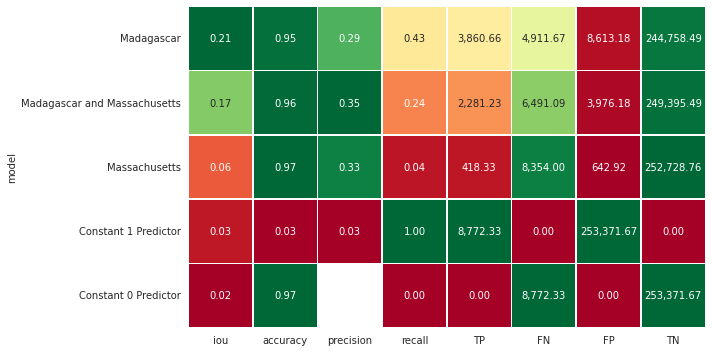

In [24]:

plt.rcParams["figure.figsize"] = (10, 5)
scaled_df = minmax_scale(df_results)
scaled_df = pd.DataFrame(scaled_df)
scaled_df.columns = df_results.columns
scaled_df.index = df_results.index
scaled_df
sns.heatmap(scaled_df, annot=df_results, fmt=",.2f",
            linewidths=.5, cmap="RdYlGn", cbar=False)
plt.tight_layout()
plt.savefig('filename.png', dpi=300)
# green is higher (per column), which is not always better


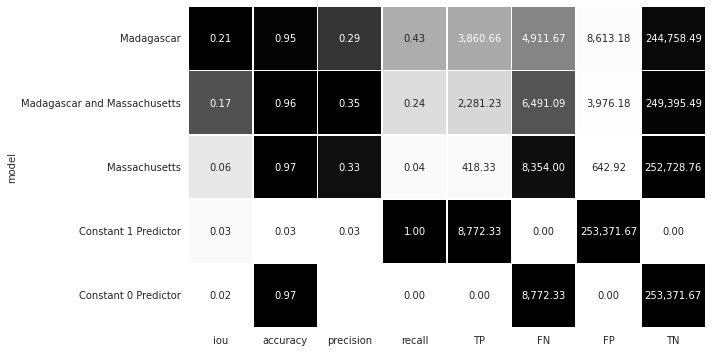

In [25]:
# same plot with sequential colormap:

sns.heatmap(scaled_df, annot=df_results, fmt=",.2f",
            linewidths=.5, cmap="Greys", cbar=False)
plt.tight_layout()
plt.savefig('filename.png', dpi=300)
# the darker, the higher the value per column


# Distribution of IoU per model:

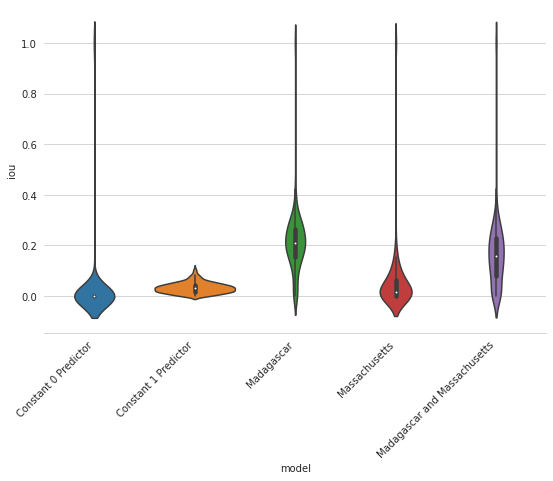

In [26]:

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(9, 6))
sns.violinplot(x='model', y='iou', data=df_results_per_image)
_ = plt.xticks(rotation=45, ha='right')
sns.despine(left=True)
# the model trained on madagascar is better at every quantile


# IoU results per model per image (Excerpt)

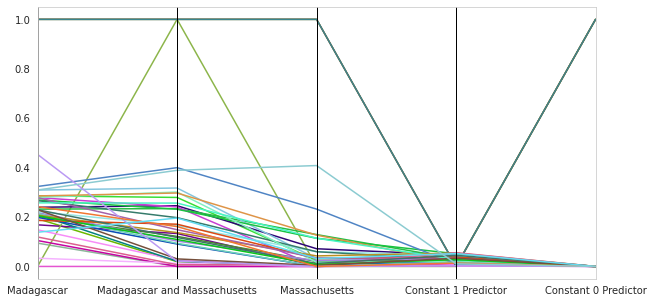

In [36]:
plt.rcParams["figure.figsize"] = (10, 5)
pd.plotting.parallel_coordinates(df_pivot.iloc[0:40].reset_index(
), class_column="image_name")  
plt.gca().legend_.remove()
#the Madagascar trained model seems to be best
#for most images
#however, there are images that other models classify better
